# TP 4 - BERT (Bidirectional Encoder Representations from Transformers)

L'objectif de ce TP est d'utiliser BERT pour l'analyse de sentiment en finetunant le modèle de base.

In [1]:
# 1. Import packages
!pip install datasets transformers accelerate

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch

# Variables to set the number of epochs and samples
num_epochs = 1 # Reduced for demo purposes (instructions say 10 but that takes hours)
num_samples = 500 # Set to -1 to use all data (but takes longer)

print("Packages imported.")


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


/Users/pierre/Desktop/CE_final/TP-Final/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Packages imported.


### Le modèle BERT (Bidirectional Encoder Representations from Transformers)
BERT a révolutionné le NLP en 2018. Contrairement à Word2Vec qui lit de gauche à droite (ou l'inverse), BERT lit toute la phrase d'un coup (mécanisme d'Attention).

- **Pre-training** : Il a lu tout Wikipedia et BookCorpus pour comprendre la langue (tâche de texte à trous).
- **Fine-tuning** : On va maintenant lui apprendre une tâche spécifique (classer des critiques de films) en ajustant légèrement ses poids.


### Explication du Tokenizer BERT (WordPiece) :
Le tokenizer de BERT est très particulier :
- **WordPiece** : Il découpe les mots rares en sous-unités fréquentes (ex:  -> , , ). Cela permet de gérer n'importe quel mot avec un vocabulaire fixe (30k tokens).
- **** : Toutes les phrases sont complétées avec des tokens  pour avoir la même longueur (nécessaire pour le calcul tensoriel).
- **** : On coupe si c'est trop long (BERT accepte max 512 tokens).


In [2]:
# 2. Load dataset
dataset = load_dataset('imdb')

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

                                                text  label
0  I rented I AM CURIOUS-YELLOW from my video sto...      0
1  "I Am Curious: Yellow" is a risible and preten...      0
2  If only to avoid making this type of film in t...      0
3  This film was probably inspired by Godard's Ma...      0
4  Oh, brother...after hearing about this ridicul...      0


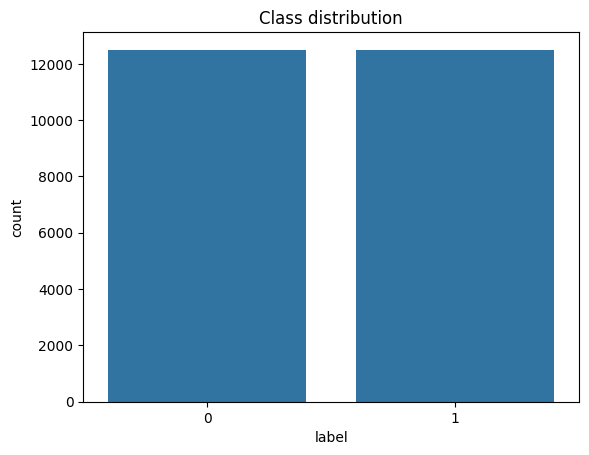

In [3]:
# 3. Explore the data
train_df = pd.DataFrame(dataset['train'])
print(train_df.head())

sns.countplot(x='label', data=train_df)
plt.title('Class distribution')
plt.show()

### Tokenisation Spécifique à BERT :
BERT ne lit pas juste des mots, il a besoin de tokens spéciaux :
- **[CLS]** : Ajouté au début de chaque phrase. C'est ce token qui servira à la classification globale (positif/négatif).
- **[SEP]** : Séparateur de phrases (moins utile ici car on a une seule phrase, mais vital pour les tâches de questions/réponses).
- **Subword Tokenization** : Il découpe les mots inconnus en morceaux (ex: "playing" -> "play" + "##ing").


In [4]:
# 4. Pre treatment, mostly tokenizer
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

In [5]:
# 5. Train – test data.
if num_samples == -1:
    small_train_dataset = tokenized_datasets["train"].shuffle(seed=42)
    small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42)
else:
    small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(num_samples))
    small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(num_samples))

print(f"Train size: {len(small_train_dataset)}")
print(f"Test size: {len(small_eval_dataset)}")

Train size: 500
Test size: 500


### Pourquoi le Transfer Learning est-il si puissant ?
Nous n'avons que 500 exemples d'entraînement ici (dans notre version rapide). Avec un réseau de neurones classique partant de zéro, le modèle n'apprendrait rien (overfitting immédiat).

Mais **BERT a déjà "lu" internet**. Il sait déjà ce que signifie "fantastic", "terrible", "movie".
Le  ne fait qu'adapter cette connaissance générale à notre format spécifique (Positif/Négatif). C'est pour cela qu'on obtient > 85% de précision même avec très peu de données.


### Chargement du modèle de classification :
On charge .
C'est le cerveau de BERT (110M de paramètres) auquel on a greffé une simple couche de neurones à la fin pour dire "Positif" ou "Négatif".

> **Note sur le Warning** : C'est normal ! Hugging Face nous prévient qu'on charge un modèle pré-entraîné (BERT) mais que la dernière couche (classification) est nouvelle et aléatoire. C'est justement ce qu'on va entraîner.


In [6]:
# 6. Load pre trained model and run the training
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

training_args = TrainingArguments(
    output_dir="test_trainer",
    eval_strategy="epoch",
    num_train_epochs=num_epochs,
)

import numpy as np
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

Loading weights:   0%| | 0/199 [00:00<?, ?i

Loading weights:   1%| | 1/199 [00:00<00:00

Loading weights:   1%| | 1/199 [00:00<00:00

Loading weights:   1%| | 2/199 [00:00<00:00

Loading weights:   1%| | 2/199 [00:00<00:00

Loading weights:   2%| | 3/199 [00:00<00:00

Loading weights:   2%| | 3/199 [00:00<00:00

Loading weights:   2%| | 4/199 [00:00<00:00

Loading weights:   2%| | 4/199 [00:00<00:00

Loading weights:   3%| | 5/199 [00:00<00:00

Loading weights:   3%| | 5/199 [00:00<00:00

Loading weights:   3%| | 6/199 [00:00<00:00

Loading weights:   3%| | 6/199 [00:00<00:00

Loading weights:   4%| | 7/199 [00:00<00:00

Loading weights:   4%| | 7/199 [00:00<00:00

Loading weights:   4%| | 8/199 [00:00<00:00

Loading weights:   4%| | 8/199 [00:00<00:00

Loading weights:   5%| | 9/199 [00:00<00:00

Loading weights:   5%| | 9/199 [00:00<00:00

Loading weights:   5%| | 10/199 [00:00<00:0

Loading weights:   5%| | 10/199 [00:00<00:0

Loading weights:   6%| | 11/199 [00:00<00:0

Loading weights:   6%| | 11/199 [00:00<00:0

Loading weights:   6%| | 12/199 [00:00<00:0

Loading weights:   6%| | 12/199 [00:00<00:0

Loading weights:   7%| | 13/199 [00:00<00:0

Loading weights:   7%| | 13/199 [00:00<00:0

Loading weights:   7%| | 14/199 [00:00<00:0

Loading weights:   7%| | 14/199 [00:00<00:0

Loading weights:   8%| | 15/199 [00:00<00:0

Loading weights:   8%| | 15/199 [00:00<00:0

Loading weights:   8%| | 16/199 [00:00<00:0

Loading weights:   8%| | 16/199 [00:00<00:0

Loading weights:   9%| | 17/199 [00:00<00:0

Loading weights:   9%| | 17/199 [00:00<00:0

Loading weights:   9%| | 18/199 [00:00<00:0

Loading weights:   9%| | 18/199 [00:00<00:0

Loading weights:  10%| | 19/199 [00:00<00:0

Loading weights:  10%| | 19/199 [00:00<00:0

Loading weights:  10%| | 20/199 [00:00<00:0

Loading weights:  10%| | 20/199 [00:00<00:0

Loading weights:  11%| | 21/199 [00:00<00:0

Loading weights:  11%| | 21/199 [00:00<00:0

Loading weights:  11%| | 22/199 [00:00<00:0

Loading weights:  11%| | 22/199 [00:00<00:0

Loading weights:  12%| | 23/199 [00:00<00:0

Loading weights:  12%| | 23/199 [00:00<00:0

Loading weights:  12%| | 24/199 [00:00<00:0

Loading weights:  12%| | 24/199 [00:00<00:0

Loading weights:  13%|▏| 25/199 [00:00<00:0

Loading weights:  13%|▏| 25/199 [00:00<00:0

Loading weights:  13%|▏| 26/199 [00:00<00:0

Loading weights:  13%|▏| 26/199 [00:00<00:0

Loading weights:  14%|▏| 27/199 [00:00<00:0

Loading weights:  14%|▏| 27/199 [00:00<00:0

Loading weights:  14%|▏| 28/199 [00:00<00:0

Loading weights:  14%|▏| 28/199 [00:00<00:0

Loading weights:  15%|▏| 29/199 [00:00<00:0

Loading weights:  15%|▏| 29/199 [00:00<00:0

Loading weights:  15%|▏| 30/199 [00:00<00:0

Loading weights:  15%|▏| 30/199 [00:00<00:0

Loading weights:  16%|▏| 31/199 [00:00<00:0

Loading weights:  16%|▏| 31/199 [00:00<00:0

Loading weights:  16%|▏| 32/199 [00:00<00:0

Loading weights:  16%|▏| 32/199 [00:00<00:0

Loading weights:  17%|▏| 33/199 [00:00<00:0

Loading weights:  17%|▏| 33/199 [00:00<00:0

Loading weights:  17%|▏| 34/199 [00:00<00:0

Loading weights:  17%|▏| 34/199 [00:00<00:0

Loading weights:  18%|▏| 35/199 [00:00<00:0

Loading weights:  18%|▏| 35/199 [00:00<00:0

Loading weights:  18%|▏| 36/199 [00:00<00:0

Loading weights:  18%|▏| 36/199 [00:00<00:0

Loading weights:  19%|▏| 37/199 [00:00<00:0

Loading weights:  19%|▏| 37/199 [00:00<00:0

Loading weights:  19%|▏| 38/199 [00:00<00:0

Loading weights:  19%|▏| 38/199 [00:00<00:0

Loading weights:  20%|▏| 39/199 [00:00<00:0

Loading weights:  20%|▏| 39/199 [00:00<00:0

Loading weights:  20%|▏| 40/199 [00:00<00:0

Loading weights:  20%|▏| 40/199 [00:00<00:0

Loading weights:  21%|▏| 41/199 [00:00<00:0

Loading weights:  21%|▏| 41/199 [00:00<00:0

Loading weights:  21%|▏| 42/199 [00:00<00:0

Loading weights:  21%|▏| 42/199 [00:00<00:0

Loading weights:  22%|▏| 43/199 [00:00<00:0

Loading weights:  22%|▏| 43/199 [00:00<00:0

Loading weights:  22%|▏| 44/199 [00:00<00:0

Loading weights:  22%|▏| 44/199 [00:00<00:0

Loading weights:  23%|▏| 45/199 [00:00<00:0

Loading weights:  23%|▏| 45/199 [00:00<00:0

Loading weights:  23%|▏| 46/199 [00:00<00:0

Loading weights:  23%|▏| 46/199 [00:00<00:0

Loading weights:  24%|▏| 47/199 [00:00<00:0

Loading weights:  24%|▏| 47/199 [00:00<00:0

Loading weights:  24%|▏| 48/199 [00:00<00:0

Loading weights:  24%|▏| 48/199 [00:00<00:0

Loading weights:  25%|▏| 49/199 [00:00<00:0

Loading weights:  25%|▏| 49/199 [00:00<00:0

Loading weights:  25%|▎| 50/199 [00:00<00:0

Loading weights:  25%|▎| 50/199 [00:00<00:0

Loading weights:  26%|▎| 51/199 [00:00<00:0

Loading weights:  26%|▎| 51/199 [00:00<00:0

Loading weights:  26%|▎| 52/199 [00:00<00:0

Loading weights:  26%|▎| 52/199 [00:00<00:0

Loading weights:  27%|▎| 53/199 [00:00<00:0

Loading weights:  27%|▎| 53/199 [00:00<00:0

Loading weights:  27%|▎| 54/199 [00:00<00:0

Loading weights:  27%|▎| 54/199 [00:00<00:0

Loading weights:  28%|▎| 55/199 [00:00<00:0

Loading weights:  28%|▎| 55/199 [00:00<00:0

Loading weights:  28%|▎| 56/199 [00:00<00:0

Loading weights:  28%|▎| 56/199 [00:00<00:0

Loading weights:  29%|▎| 57/199 [00:00<00:0

Loading weights:  29%|▎| 57/199 [00:00<00:0

Loading weights:  29%|▎| 58/199 [00:00<00:0

Loading weights:  29%|▎| 58/199 [00:00<00:0

Loading weights:  30%|▎| 59/199 [00:00<00:0

Loading weights:  30%|▎| 59/199 [00:00<00:0

Loading weights:  30%|▎| 60/199 [00:00<00:0

Loading weights:  30%|▎| 60/199 [00:00<00:0

Loading weights:  31%|▎| 61/199 [00:00<00:0

Loading weights:  31%|▎| 61/199 [00:00<00:0

Loading weights:  31%|▎| 62/199 [00:00<00:0

Loading weights:  31%|▎| 62/199 [00:00<00:0

Loading weights:  32%|▎| 63/199 [00:00<00:0

Loading weights:  32%|▎| 63/199 [00:00<00:0

Loading weights:  32%|▎| 64/199 [00:00<00:0

Loading weights:  32%|▎| 64/199 [00:00<00:0

Loading weights:  33%|▎| 65/199 [00:00<00:0

Loading weights:  33%|▎| 65/199 [00:00<00:0

Loading weights:  33%|▎| 66/199 [00:00<00:0

Loading weights:  33%|▎| 66/199 [00:00<00:0

Loading weights:  34%|▎| 67/199 [00:00<00:0

Loading weights:  34%|▎| 67/199 [00:00<00:0

Loading weights:  34%|▎| 68/199 [00:00<00:0

Loading weights:  34%|▎| 68/199 [00:00<00:0

Loading weights:  35%|▎| 69/199 [00:00<00:0

Loading weights:  35%|▎| 69/199 [00:00<00:0

Loading weights:  35%|▎| 70/199 [00:00<00:0

Loading weights:  35%|▎| 70/199 [00:00<00:0

Loading weights:  36%|▎| 71/199 [00:00<00:0

Loading weights:  36%|▎| 71/199 [00:00<00:0

Loading weights:  36%|▎| 72/199 [00:00<00:0

Loading weights:  36%|▎| 72/199 [00:00<00:0

Loading weights:  37%|▎| 73/199 [00:00<00:0

Loading weights:  37%|▎| 73/199 [00:00<00:0

Loading weights:  37%|▎| 74/199 [00:00<00:0

Loading weights:  37%|▎| 74/199 [00:00<00:0

Loading weights:  38%|▍| 75/199 [00:00<00:0

Loading weights:  38%|▍| 75/199 [00:00<00:0

Loading weights:  38%|▍| 76/199 [00:00<00:0

Loading weights:  38%|▍| 76/199 [00:00<00:0

Loading weights:  39%|▍| 77/199 [00:00<00:0

Loading weights:  39%|▍| 77/199 [00:00<00:0

Loading weights:  39%|▍| 78/199 [00:00<00:0

Loading weights:  39%|▍| 78/199 [00:00<00:0

Loading weights:  40%|▍| 79/199 [00:00<00:0

Loading weights:  40%|▍| 79/199 [00:00<00:0

Loading weights:  40%|▍| 80/199 [00:00<00:0

Loading weights:  40%|▍| 80/199 [00:00<00:0

Loading weights:  41%|▍| 81/199 [00:00<00:0

Loading weights:  41%|▍| 81/199 [00:00<00:0

Loading weights:  41%|▍| 82/199 [00:00<00:0

Loading weights:  41%|▍| 82/199 [00:00<00:0

Loading weights:  42%|▍| 83/199 [00:00<00:0

Loading weights:  42%|▍| 83/199 [00:00<00:0

Loading weights:  42%|▍| 84/199 [00:00<00:0

Loading weights:  42%|▍| 84/199 [00:00<00:0

Loading weights:  43%|▍| 85/199 [00:00<00:0

Loading weights:  43%|▍| 85/199 [00:00<00:0

Loading weights:  43%|▍| 86/199 [00:00<00:0

Loading weights:  43%|▍| 86/199 [00:00<00:0

Loading weights:  44%|▍| 87/199 [00:00<00:0

Loading weights:  44%|▍| 87/199 [00:00<00:0

Loading weights:  44%|▍| 88/199 [00:00<00:0

Loading weights:  44%|▍| 88/199 [00:00<00:0

Loading weights:  45%|▍| 89/199 [00:00<00:0

Loading weights:  45%|▍| 89/199 [00:00<00:0

Loading weights:  45%|▍| 90/199 [00:00<00:0

Loading weights:  45%|▍| 90/199 [00:00<00:0

Loading weights:  46%|▍| 91/199 [00:00<00:0

Loading weights:  46%|▍| 91/199 [00:00<00:0

Loading weights:  46%|▍| 92/199 [00:00<00:0

Loading weights:  46%|▍| 92/199 [00:00<00:0

Loading weights:  47%|▍| 93/199 [00:00<00:0

Loading weights:  47%|▍| 93/199 [00:00<00:0

Loading weights:  47%|▍| 94/199 [00:00<00:0

Loading weights:  47%|▍| 94/199 [00:00<00:0

Loading weights:  48%|▍| 95/199 [00:00<00:0

Loading weights:  48%|▍| 95/199 [00:00<00:0

Loading weights:  48%|▍| 96/199 [00:00<00:0

Loading weights:  48%|▍| 96/199 [00:00<00:0

Loading weights:  49%|▍| 97/199 [00:00<00:0

Loading weights:  49%|▍| 97/199 [00:00<00:0

Loading weights:  49%|▍| 98/199 [00:00<00:0

Loading weights:  49%|▍| 98/199 [00:00<00:0

Loading weights:  50%|▍| 99/199 [00:00<00:0

Loading weights:  50%|▍| 99/199 [00:00<00:0

Loading weights:  50%|▌| 100/199 [00:00<00:

Loading weights:  50%|▌| 100/199 [00:00<00:

Loading weights:  51%|▌| 101/199 [00:00<00:

Loading weights:  51%|▌| 101/199 [00:00<00:

Loading weights:  51%|▌| 102/199 [00:00<00:

Loading weights:  51%|▌| 102/199 [00:00<00:

Loading weights:  52%|▌| 103/199 [00:00<00:

Loading weights:  52%|▌| 103/199 [00:00<00:

Loading weights:  52%|▌| 104/199 [00:00<00:

Loading weights:  52%|▌| 104/199 [00:00<00:

Loading weights:  53%|▌| 105/199 [00:00<00:

Loading weights:  53%|▌| 105/199 [00:00<00:

Loading weights:  53%|▌| 106/199 [00:00<00:

Loading weights:  53%|▌| 106/199 [00:00<00:

Loading weights:  54%|▌| 107/199 [00:00<00:

Loading weights:  54%|▌| 107/199 [00:00<00:

Loading weights:  54%|▌| 108/199 [00:00<00:

Loading weights:  54%|▌| 108/199 [00:00<00:

Loading weights:  55%|▌| 109/199 [00:00<00:

Loading weights:  55%|▌| 109/199 [00:00<00:

Loading weights:  55%|▌| 110/199 [00:00<00:

Loading weights:  55%|▌| 110/199 [00:00<00:

Loading weights:  56%|▌| 111/199 [00:00<00:

Loading weights:  56%|▌| 111/199 [00:00<00:

Loading weights:  56%|▌| 112/199 [00:00<00:

Loading weights:  56%|▌| 112/199 [00:00<00:

Loading weights:  57%|▌| 113/199 [00:00<00:

Loading weights:  57%|▌| 113/199 [00:00<00:

Loading weights:  57%|▌| 114/199 [00:00<00:

Loading weights:  57%|▌| 114/199 [00:00<00:

Loading weights:  58%|▌| 115/199 [00:00<00:

Loading weights:  58%|▌| 115/199 [00:00<00:

Loading weights:  58%|▌| 116/199 [00:00<00:

Loading weights:  58%|▌| 116/199 [00:00<00:

Loading weights:  59%|▌| 117/199 [00:00<00:

Loading weights:  59%|▌| 117/199 [00:00<00:

Loading weights:  59%|▌| 118/199 [00:00<00:

Loading weights:  59%|▌| 118/199 [00:00<00:

Loading weights:  60%|▌| 119/199 [00:00<00:

Loading weights:  60%|▌| 119/199 [00:00<00:

Loading weights:  60%|▌| 120/199 [00:00<00:

Loading weights:  60%|▌| 120/199 [00:00<00:

Loading weights:  61%|▌| 121/199 [00:00<00:

Loading weights:  61%|▌| 121/199 [00:00<00:

Loading weights:  61%|▌| 122/199 [00:00<00:

Loading weights:  61%|▌| 122/199 [00:00<00:

Loading weights:  62%|▌| 123/199 [00:00<00:

Loading weights:  62%|▌| 123/199 [00:00<00:

Loading weights:  62%|▌| 124/199 [00:00<00:

Loading weights:  62%|▌| 124/199 [00:00<00:

Loading weights:  63%|▋| 125/199 [00:00<00:

Loading weights:  63%|▋| 125/199 [00:00<00:

Loading weights:  63%|▋| 126/199 [00:00<00:

Loading weights:  63%|▋| 126/199 [00:00<00:

Loading weights:  64%|▋| 127/199 [00:00<00:

Loading weights:  64%|▋| 127/199 [00:00<00:

Loading weights:  64%|▋| 128/199 [00:00<00:

Loading weights:  64%|▋| 128/199 [00:00<00:

Loading weights:  65%|▋| 129/199 [00:00<00:

Loading weights:  65%|▋| 129/199 [00:00<00:

Loading weights:  65%|▋| 130/199 [00:00<00:

Loading weights:  65%|▋| 130/199 [00:00<00:

Loading weights:  66%|▋| 131/199 [00:00<00:

Loading weights:  66%|▋| 131/199 [00:00<00:

Loading weights:  66%|▋| 132/199 [00:00<00:

Loading weights:  66%|▋| 132/199 [00:00<00:

Loading weights:  67%|▋| 133/199 [00:00<00:

Loading weights:  67%|▋| 133/199 [00:00<00:

Loading weights:  67%|▋| 134/199 [00:00<00:

Loading weights:  67%|▋| 134/199 [00:00<00:

Loading weights:  68%|▋| 135/199 [00:00<00:

Loading weights:  68%|▋| 135/199 [00:00<00:

Loading weights:  68%|▋| 136/199 [00:00<00:

Loading weights:  68%|▋| 136/199 [00:00<00:

Loading weights:  69%|▋| 137/199 [00:00<00:

Loading weights:  69%|▋| 137/199 [00:00<00:

Loading weights:  69%|▋| 138/199 [00:00<00:

Loading weights:  69%|▋| 138/199 [00:00<00:

Loading weights:  70%|▋| 139/199 [00:00<00:

Loading weights:  70%|▋| 139/199 [00:00<00:

Loading weights:  70%|▋| 140/199 [00:00<00:

Loading weights:  70%|▋| 140/199 [00:00<00:

Loading weights:  71%|▋| 141/199 [00:00<00:

Loading weights:  71%|▋| 141/199 [00:00<00:

Loading weights:  71%|▋| 142/199 [00:00<00:

Loading weights:  71%|▋| 142/199 [00:00<00:

Loading weights:  72%|▋| 143/199 [00:00<00:

Loading weights:  72%|▋| 143/199 [00:00<00:

Loading weights:  72%|▋| 144/199 [00:00<00:

Loading weights:  72%|▋| 144/199 [00:00<00:

Loading weights:  73%|▋| 145/199 [00:00<00:

Loading weights:  73%|▋| 145/199 [00:00<00:

Loading weights:  73%|▋| 146/199 [00:00<00:

Loading weights:  73%|▋| 146/199 [00:00<00:

Loading weights:  74%|▋| 147/199 [00:00<00:

Loading weights:  74%|▋| 147/199 [00:00<00:

Loading weights:  74%|▋| 148/199 [00:00<00:

Loading weights:  74%|▋| 148/199 [00:00<00:

Loading weights:  75%|▋| 149/199 [00:00<00:

Loading weights:  75%|▋| 149/199 [00:00<00:

Loading weights:  75%|▊| 150/199 [00:00<00:

Loading weights:  75%|▊| 150/199 [00:00<00:

Loading weights:  76%|▊| 151/199 [00:00<00:

Loading weights:  76%|▊| 151/199 [00:00<00:

Loading weights:  76%|▊| 152/199 [00:00<00:

Loading weights:  76%|▊| 152/199 [00:00<00:

Loading weights:  77%|▊| 153/199 [00:00<00:

Loading weights:  77%|▊| 153/199 [00:00<00:

Loading weights:  77%|▊| 154/199 [00:00<00:

Loading weights:  77%|▊| 154/199 [00:00<00:

Loading weights:  78%|▊| 155/199 [00:00<00:

Loading weights:  78%|▊| 155/199 [00:00<00:

Loading weights:  78%|▊| 156/199 [00:00<00:

Loading weights:  78%|▊| 156/199 [00:00<00:

Loading weights:  79%|▊| 157/199 [00:00<00:

Loading weights:  79%|▊| 157/199 [00:00<00:

Loading weights:  79%|▊| 158/199 [00:00<00:

Loading weights:  79%|▊| 158/199 [00:00<00:

Loading weights:  80%|▊| 159/199 [00:00<00:

Loading weights:  80%|▊| 159/199 [00:00<00:

Loading weights:  80%|▊| 160/199 [00:00<00:

Loading weights:  80%|▊| 160/199 [00:00<00:

Loading weights:  81%|▊| 161/199 [00:00<00:

Loading weights:  81%|▊| 161/199 [00:00<00:

Loading weights:  81%|▊| 162/199 [00:00<00:

Loading weights:  81%|▊| 162/199 [00:00<00:

Loading weights:  82%|▊| 163/199 [00:00<00:

Loading weights:  82%|▊| 163/199 [00:00<00:

Loading weights:  82%|▊| 164/199 [00:00<00:

Loading weights:  82%|▊| 164/199 [00:00<00:

Loading weights:  83%|▊| 165/199 [00:00<00:

Loading weights:  83%|▊| 165/199 [00:00<00:

Loading weights:  83%|▊| 166/199 [00:00<00:

Loading weights:  83%|▊| 166/199 [00:00<00:

Loading weights:  84%|▊| 167/199 [00:00<00:

Loading weights:  84%|▊| 167/199 [00:00<00:

Loading weights:  84%|▊| 168/199 [00:00<00:

Loading weights:  84%|▊| 168/199 [00:00<00:

Loading weights:  85%|▊| 169/199 [00:00<00:

Loading weights:  85%|▊| 169/199 [00:00<00:

Loading weights:  85%|▊| 170/199 [00:00<00:

Loading weights:  85%|▊| 170/199 [00:00<00:

Loading weights:  86%|▊| 171/199 [00:00<00:

Loading weights:  86%|▊| 171/199 [00:00<00:

Loading weights:  86%|▊| 172/199 [00:00<00:

Loading weights:  86%|▊| 172/199 [00:00<00:

Loading weights:  87%|▊| 173/199 [00:00<00:

Loading weights:  87%|▊| 173/199 [00:00<00:

Loading weights:  87%|▊| 174/199 [00:00<00:

Loading weights:  87%|▊| 174/199 [00:00<00:

Loading weights:  88%|▉| 175/199 [00:00<00:

Loading weights:  88%|▉| 175/199 [00:00<00:

Loading weights:  88%|▉| 176/199 [00:00<00:

Loading weights:  88%|▉| 176/199 [00:00<00:

Loading weights:  89%|▉| 177/199 [00:00<00:

Loading weights:  89%|▉| 177/199 [00:00<00:

Loading weights:  89%|▉| 178/199 [00:00<00:

Loading weights:  89%|▉| 178/199 [00:00<00:

Loading weights:  90%|▉| 179/199 [00:00<00:

Loading weights:  90%|▉| 179/199 [00:00<00:

Loading weights:  90%|▉| 180/199 [00:00<00:

Loading weights:  90%|▉| 180/199 [00:00<00:

Loading weights:  91%|▉| 181/199 [00:00<00:

Loading weights:  91%|▉| 181/199 [00:00<00:

Loading weights:  91%|▉| 182/199 [00:00<00:

Loading weights:  91%|▉| 182/199 [00:00<00:

Loading weights:  92%|▉| 183/199 [00:00<00:

Loading weights:  92%|▉| 183/199 [00:00<00:

Loading weights:  92%|▉| 184/199 [00:00<00:

Loading weights:  92%|▉| 184/199 [00:00<00:

Loading weights:  93%|▉| 185/199 [00:00<00:

Loading weights:  93%|▉| 185/199 [00:00<00:

Loading weights:  93%|▉| 186/199 [00:00<00:

Loading weights:  93%|▉| 186/199 [00:00<00:

Loading weights:  94%|▉| 187/199 [00:00<00:

Loading weights:  94%|▉| 187/199 [00:00<00:

Loading weights:  94%|▉| 188/199 [00:00<00:

Loading weights:  94%|▉| 188/199 [00:00<00:

Loading weights:  95%|▉| 189/199 [00:00<00:

Loading weights:  95%|▉| 189/199 [00:00<00:

Loading weights:  95%|▉| 190/199 [00:00<00:

Loading weights:  95%|▉| 190/199 [00:00<00:

Loading weights:  96%|▉| 191/199 [00:00<00:

Loading weights:  96%|▉| 191/199 [00:00<00:

Loading weights:  96%|▉| 192/199 [00:00<00:

Loading weights:  96%|▉| 192/199 [00:00<00:

Loading weights:  97%|▉| 193/199 [00:00<00:

Loading weights:  97%|▉| 193/199 [00:00<00:

Loading weights:  97%|▉| 194/199 [00:00<00:

Loading weights:  97%|▉| 194/199 [00:00<00:

Loading weights:  98%|▉| 195/199 [00:00<00:

Loading weights:  98%|▉| 195/199 [00:00<00:

Loading weights:  98%|▉| 196/199 [00:00<00:

Loading weights:  98%|▉| 196/199 [00:00<00:

Loading weights:  99%|▉| 197/199 [00:00<00:

Loading weights:  99%|▉| 197/199 [00:00<00:

Loading weights:  99%|▉| 198/199 [00:00<00:

Loading weights:  99%|▉| 198/199 [00:00<00:

Loading weights: 100%|█| 199/199 [00:00<00:

Loading weights: 100%|█| 199/199 [00:00<00:

Loading weights: 100%|█| 199/199 [00:00<00:


BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


/Users/pierre/Desktop/CE_final/TP-Final/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.351660,0.874000


Writing model shards:   0%| | 0/1 [00:00<?,

Writing model shards: 100%|█| 1/1 [00:00<00

Writing model shards: 100%|█| 1/1 [00:00<00

/Users/pierre/Desktop/CE_final/TP-Final/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


TrainOutput(global_step=63, training_loss=0.5756801423572359, metrics={'train_runtime': 117.1457, 'train_samples_per_second': 4.268, 'train_steps_per_second': 0.538, 'total_flos': 131555527680000.0, 'train_loss': 0.5756801423572359, 'epoch': 1.0})

### Entraînement (Fine-Tuning) :
On utilise l'API  de Hugging Face qui gère tout (boucles, batchs, GPU...).
On ne fait que peu d'époques (ici 1 pour la démo, idéalement 2 ou 3) car le modèle sait déjà lire l'anglais, il a juste besoin de comprendre la tâche.


/Users/pierre/Desktop/CE_final/TP-Final/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Accuracy: 0.874


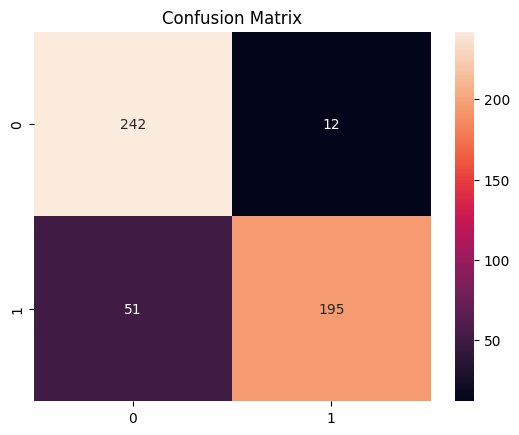

In [7]:
# 7. Evaluation
predictions = trainer.predict(small_eval_dataset)
preds = np.argmax(predictions.predictions, axis=-1)

print("Accuracy:", accuracy_score(small_eval_dataset['label'], preds))

cm = confusion_matrix(small_eval_dataset['label'], preds)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

In [8]:
# 8. Inference on a new sample
text = "This is a fantastic movie. I really enjoyed it."
inputs = tokenizer(text, padding="max_length", truncation=True, max_length=512, return_tensors="pt")

# Move inputs to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():
    logits = model(**inputs).logits

predicted_class_id = logits.argmax().item()
print(f"Text: {text}")
print(f"Pred: {predicted_class_id} ({'Positive' if predicted_class_id == 1 else 'Negative'})")

Text: This is a fantastic movie. I really enjoyed it.
Pred: 1 (Positive)


## Test d'Inférence sur des Phrases Personnalisées

Vérifions la généralisation du modèle sur des phrases jamais vues.


In [9]:
# Test sur de nouvelles phrases
import torch

custom_sentences = [
    "This movie was absolutely fantastic! I loved every minute of it.",
    "Worst film ever. The acting was terrible and the plot made no sense.",
    "It was okay, not great but watchable.",
    "I fell asleep after 10 minutes. Boring."
]

model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print("=== Résultats d'inférence ===")
for sentence in custom_sentences:
    inputs = tokenizer(sentence, return_tensors='pt', truncation=True, padding='max_length', max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    pred_label = torch.argmax(probs, dim=-1).item()
    confidence = probs[0][pred_label].item()
    label_str = 'POSITIF' if pred_label == 1 else 'NÉGATIF'
    
    print(f'  "{sentence}"')
    print(f'  -> {label_str} (confiance: {confidence:.2%})')
    print()


=== Résultats d'inférence ===
  "This movie was absolutely fantastic! I loved every minute of it."
  -> POSITIF (confiance: 72.50%)



  "Worst film ever. The acting was terrible and the plot made no sense."
  -> NÉGATIF (confiance: 88.61%)

  "It was okay, not great but watchable."
  -> POSITIF (confiance: 59.75%)



  "I fell asleep after 10 minutes. Boring."
  -> NÉGATIF (confiance: 85.56%)



### Observations :

- Le modèle identifie correctement les sentiments **positifs** ("fantastic", "loved") et **négatifs** ("worst", "terrible", "boring").
- Les phrases **ambiguës** ("okay, not great but watchable") peuvent hésiter, surtout avec peu d'entraînement (1 époque, 500 exemples).
- **Transfer Learning** : Même avec très peu de données, BERT atteint une précision raisonnable car il a déjà appris la langue anglaise sur un énorme corpus (Wikipedia + BookCorpus).

**Pour améliorer** : augmenter `num_samples` et `num_train_epochs` (2-3 époques, tout le dataset).


---

## 9. Impact du Nombre d'Exemples et d'Époques

La confiance du modèle précédent (~51%) est faible car on n'a utilisé que **500 exemples**
et **1 seule époque**. Voyons l'effet d'augmenter ces paramètres.


In [10]:
# Re-entrainement avec plus de donnees et plus d'epoques
import time

configs = [
    {'samples': 500,  'epochs': 1},  # baseline (deja fait)
    {'samples': 1000, 'epochs': 2},  # plus de donnees + epoques
]

results_comparison = []

for config in configs:
    n_samples = config['samples']
    n_epochs = config['epochs']
    print(f"\n{'='*60}")
    print(f"Training: {n_samples} samples, {n_epochs} epochs")
    print(f"{'='*60}")
    
    # Subset des donnees
    train_sub = tokenized_datasets['train'].shuffle(seed=42).select(range(n_samples))
    eval_sub = tokenized_datasets['test'].shuffle(seed=42).select(range(min(n_samples, 500)))
    
    # Nouveau modele (from scratch a chaque fois)
    model_new = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
    
    training_args_new = TrainingArguments(
        output_dir=f'test_trainer_{n_samples}_{n_epochs}',
        eval_strategy='epoch',
        num_train_epochs=n_epochs,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        logging_steps=50,
        save_strategy='no',
    )
    
    trainer_new = Trainer(
        model=model_new,
        args=training_args_new,
        train_dataset=train_sub,
        eval_dataset=eval_sub,
        compute_metrics=compute_metrics,
    )
    
    start = time.time()
    trainer_new.train()
    elapsed = time.time() - start
    
    # Evaluation
    eval_results = trainer_new.evaluate()
    acc = eval_results['eval_accuracy']
    loss = eval_results['eval_loss']
    
    results_comparison.append({
        'samples': n_samples,
        'epochs': n_epochs,
        'accuracy': acc,
        'loss': loss,
        'time_min': elapsed / 60
    })
    
    print(f"\nAccuracy: {acc:.4f}")
    print(f"Loss: {loss:.4f}")
    print(f"Time: {elapsed/60:.1f} min")

# Garder le meilleur modele pour l'inference
model = model_new
trainer = trainer_new



Training: 500 samples, 1 epochs


Loading weights:   0%| | 0/199 [00:00<?, ?i

Loading weights:   1%| | 1/199 [00:00<00:00

Loading weights:   1%| | 1/199 [00:00<00:00

Loading weights:   1%| | 2/199 [00:00<00:00

Loading weights:   1%| | 2/199 [00:00<00:00

Loading weights:   2%| | 3/199 [00:00<00:00

Loading weights:   2%| | 3/199 [00:00<00:00

Loading weights:   2%| | 4/199 [00:00<00:00

Loading weights:   2%| | 4/199 [00:00<00:00

Loading weights:   3%| | 5/199 [00:00<00:00

Loading weights:   3%| | 5/199 [00:00<00:00

Loading weights:   3%| | 6/199 [00:00<00:00

Loading weights:   3%| | 6/199 [00:00<00:00

Loading weights:   4%| | 7/199 [00:00<00:00

Loading weights:   4%| | 7/199 [00:00<00:00

Loading weights:   4%| | 8/199 [00:00<00:00

Loading weights:   4%| | 8/199 [00:00<00:00

Loading weights:   5%| | 9/199 [00:00<00:00

Loading weights:   5%| | 9/199 [00:00<00:00

Loading weights:   5%| | 10/199 [00:00<00:0

Loading weights:   5%| | 10/199 [00:00<00:0

Loading weights:   6%| | 11/199 [00:00<00:0

Loading weights:   6%| | 11/199 [00:00<00:0

Loading weights:   6%| | 12/199 [00:00<00:0

Loading weights:   6%| | 12/199 [00:00<00:0

Loading weights:   7%| | 13/199 [00:00<00:0

Loading weights:   7%| | 13/199 [00:00<00:0

Loading weights:   7%| | 14/199 [00:00<00:0

Loading weights:   7%| | 14/199 [00:00<00:0

Loading weights:   8%| | 15/199 [00:00<00:0

Loading weights:   8%| | 15/199 [00:00<00:0

Loading weights:   8%| | 16/199 [00:00<00:0

Loading weights:   8%| | 16/199 [00:00<00:0

Loading weights:   9%| | 17/199 [00:00<00:0

Loading weights:   9%| | 17/199 [00:00<00:0

Loading weights:   9%| | 18/199 [00:00<00:0

Loading weights:   9%| | 18/199 [00:00<00:0

Loading weights:  10%| | 19/199 [00:00<00:0

Loading weights:  10%| | 19/199 [00:00<00:0

Loading weights:  10%| | 20/199 [00:00<00:0

Loading weights:  10%| | 20/199 [00:00<00:0

Loading weights:  11%| | 21/199 [00:00<00:0

Loading weights:  11%| | 21/199 [00:00<00:0

Loading weights:  11%| | 22/199 [00:00<00:0

Loading weights:  11%| | 22/199 [00:00<00:0

Loading weights:  12%| | 23/199 [00:00<00:0

Loading weights:  12%| | 23/199 [00:00<00:0

Loading weights:  12%| | 24/199 [00:00<00:0

Loading weights:  12%| | 24/199 [00:00<00:0

Loading weights:  13%|▏| 25/199 [00:00<00:0

Loading weights:  13%|▏| 25/199 [00:00<00:0

Loading weights:  13%|▏| 26/199 [00:00<00:0

Loading weights:  13%|▏| 26/199 [00:00<00:0

Loading weights:  14%|▏| 27/199 [00:00<00:0

Loading weights:  14%|▏| 27/199 [00:00<00:0

Loading weights:  14%|▏| 28/199 [00:00<00:0

Loading weights:  14%|▏| 28/199 [00:00<00:0

Loading weights:  15%|▏| 29/199 [00:00<00:0

Loading weights:  15%|▏| 29/199 [00:00<00:0

Loading weights:  15%|▏| 30/199 [00:00<00:0

Loading weights:  15%|▏| 30/199 [00:00<00:0

Loading weights:  16%|▏| 31/199 [00:00<00:0

Loading weights:  16%|▏| 31/199 [00:00<00:0

Loading weights:  16%|▏| 32/199 [00:00<00:0

Loading weights:  16%|▏| 32/199 [00:00<00:0

Loading weights:  17%|▏| 33/199 [00:00<00:0

Loading weights:  17%|▏| 33/199 [00:00<00:0

Loading weights:  17%|▏| 34/199 [00:00<00:0

Loading weights:  17%|▏| 34/199 [00:00<00:0

Loading weights:  18%|▏| 35/199 [00:00<00:0

Loading weights:  18%|▏| 35/199 [00:00<00:0

Loading weights:  18%|▏| 36/199 [00:00<00:0

Loading weights:  18%|▏| 36/199 [00:00<00:0

Loading weights:  19%|▏| 37/199 [00:00<00:0

Loading weights:  19%|▏| 37/199 [00:00<00:0

Loading weights:  19%|▏| 38/199 [00:00<00:0

Loading weights:  19%|▏| 38/199 [00:00<00:0

Loading weights:  20%|▏| 39/199 [00:00<00:0

Loading weights:  20%|▏| 39/199 [00:00<00:0

Loading weights:  20%|▏| 40/199 [00:00<00:0

Loading weights:  20%|▏| 40/199 [00:00<00:0

Loading weights:  21%|▏| 41/199 [00:00<00:0

Loading weights:  21%|▏| 41/199 [00:00<00:0

Loading weights:  21%|▏| 42/199 [00:00<00:0

Loading weights:  21%|▏| 42/199 [00:00<00:0

Loading weights:  22%|▏| 43/199 [00:00<00:0

Loading weights:  22%|▏| 43/199 [00:00<00:0

Loading weights:  22%|▏| 44/199 [00:00<00:0

Loading weights:  22%|▏| 44/199 [00:00<00:0

Loading weights:  23%|▏| 45/199 [00:00<00:0

Loading weights:  23%|▏| 45/199 [00:00<00:0

Loading weights:  23%|▏| 46/199 [00:00<00:0

Loading weights:  23%|▏| 46/199 [00:00<00:0

Loading weights:  24%|▏| 47/199 [00:00<00:0

Loading weights:  24%|▏| 47/199 [00:00<00:0

Loading weights:  24%|▏| 48/199 [00:00<00:0

Loading weights:  24%|▏| 48/199 [00:00<00:0

Loading weights:  25%|▏| 49/199 [00:00<00:0

Loading weights:  25%|▏| 49/199 [00:00<00:0

Loading weights:  25%|▎| 50/199 [00:00<00:0

Loading weights:  25%|▎| 50/199 [00:00<00:0

Loading weights:  26%|▎| 51/199 [00:00<00:0

Loading weights:  26%|▎| 51/199 [00:00<00:0

Loading weights:  26%|▎| 52/199 [00:00<00:0

Loading weights:  26%|▎| 52/199 [00:00<00:0

Loading weights:  27%|▎| 53/199 [00:00<00:0

Loading weights:  27%|▎| 53/199 [00:00<00:0

Loading weights:  27%|▎| 54/199 [00:00<00:0

Loading weights:  27%|▎| 54/199 [00:00<00:0

Loading weights:  28%|▎| 55/199 [00:00<00:0

Loading weights:  28%|▎| 55/199 [00:00<00:0

Loading weights:  28%|▎| 56/199 [00:00<00:0

Loading weights:  28%|▎| 56/199 [00:00<00:0

Loading weights:  29%|▎| 57/199 [00:00<00:0

Loading weights:  29%|▎| 57/199 [00:00<00:0

Loading weights:  29%|▎| 58/199 [00:00<00:0

Loading weights:  29%|▎| 58/199 [00:00<00:0

Loading weights:  30%|▎| 59/199 [00:00<00:0

Loading weights:  30%|▎| 59/199 [00:00<00:0

Loading weights:  30%|▎| 60/199 [00:00<00:0

Loading weights:  30%|▎| 60/199 [00:00<00:0

Loading weights:  31%|▎| 61/199 [00:00<00:0

Loading weights:  31%|▎| 61/199 [00:00<00:0

Loading weights:  31%|▎| 62/199 [00:00<00:0

Loading weights:  31%|▎| 62/199 [00:00<00:0

Loading weights:  32%|▎| 63/199 [00:00<00:0

Loading weights:  32%|▎| 63/199 [00:00<00:0

Loading weights:  32%|▎| 64/199 [00:00<00:0

Loading weights:  32%|▎| 64/199 [00:00<00:0

Loading weights:  33%|▎| 65/199 [00:00<00:0

Loading weights:  33%|▎| 65/199 [00:00<00:0

Loading weights:  33%|▎| 66/199 [00:00<00:0

Loading weights:  33%|▎| 66/199 [00:00<00:0

Loading weights:  34%|▎| 67/199 [00:00<00:0

Loading weights:  34%|▎| 67/199 [00:00<00:0

Loading weights:  34%|▎| 68/199 [00:00<00:0

Loading weights:  34%|▎| 68/199 [00:00<00:0

Loading weights:  35%|▎| 69/199 [00:00<00:0

Loading weights:  35%|▎| 69/199 [00:00<00:0

Loading weights:  35%|▎| 70/199 [00:00<00:0

Loading weights:  35%|▎| 70/199 [00:00<00:0

Loading weights:  36%|▎| 71/199 [00:00<00:0

Loading weights:  36%|▎| 71/199 [00:00<00:0

Loading weights:  36%|▎| 72/199 [00:00<00:0

Loading weights:  36%|▎| 72/199 [00:00<00:0

Loading weights:  37%|▎| 73/199 [00:00<00:0

Loading weights:  37%|▎| 73/199 [00:00<00:0

Loading weights:  37%|▎| 74/199 [00:00<00:0

Loading weights:  37%|▎| 74/199 [00:00<00:0

Loading weights:  38%|▍| 75/199 [00:00<00:0

Loading weights:  38%|▍| 75/199 [00:00<00:0

Loading weights:  38%|▍| 76/199 [00:00<00:0

Loading weights:  38%|▍| 76/199 [00:00<00:0

Loading weights:  39%|▍| 77/199 [00:00<00:0

Loading weights:  39%|▍| 77/199 [00:00<00:0

Loading weights:  39%|▍| 78/199 [00:00<00:0

Loading weights:  39%|▍| 78/199 [00:00<00:0

Loading weights:  40%|▍| 79/199 [00:00<00:0

Loading weights:  40%|▍| 79/199 [00:00<00:0

Loading weights:  40%|▍| 80/199 [00:00<00:0

Loading weights:  40%|▍| 80/199 [00:00<00:0

Loading weights:  41%|▍| 81/199 [00:00<00:0

Loading weights:  41%|▍| 81/199 [00:00<00:0

Loading weights:  41%|▍| 82/199 [00:00<00:0

Loading weights:  41%|▍| 82/199 [00:00<00:0

Loading weights:  42%|▍| 83/199 [00:00<00:0

Loading weights:  42%|▍| 83/199 [00:00<00:0

Loading weights:  42%|▍| 84/199 [00:00<00:0

Loading weights:  42%|▍| 84/199 [00:00<00:0

Loading weights:  43%|▍| 85/199 [00:00<00:0

Loading weights:  43%|▍| 85/199 [00:00<00:0

Loading weights:  43%|▍| 86/199 [00:00<00:0

Loading weights:  43%|▍| 86/199 [00:00<00:0

Loading weights:  44%|▍| 87/199 [00:00<00:0

Loading weights:  44%|▍| 87/199 [00:00<00:0

Loading weights:  44%|▍| 88/199 [00:00<00:0

Loading weights:  44%|▍| 88/199 [00:00<00:0

Loading weights:  45%|▍| 89/199 [00:00<00:0

Loading weights:  45%|▍| 89/199 [00:00<00:0

Loading weights:  45%|▍| 90/199 [00:00<00:0

Loading weights:  45%|▍| 90/199 [00:00<00:0

Loading weights:  46%|▍| 91/199 [00:00<00:0

Loading weights:  46%|▍| 91/199 [00:00<00:0

Loading weights:  46%|▍| 92/199 [00:00<00:0

Loading weights:  46%|▍| 92/199 [00:00<00:0

Loading weights:  47%|▍| 93/199 [00:00<00:0

Loading weights:  47%|▍| 93/199 [00:00<00:0

Loading weights:  47%|▍| 94/199 [00:00<00:0

Loading weights:  47%|▍| 94/199 [00:00<00:0

Loading weights:  48%|▍| 95/199 [00:00<00:0

Loading weights:  48%|▍| 95/199 [00:00<00:0

Loading weights:  48%|▍| 96/199 [00:00<00:0

Loading weights:  48%|▍| 96/199 [00:00<00:0

Loading weights:  49%|▍| 97/199 [00:00<00:0

Loading weights:  49%|▍| 97/199 [00:00<00:0

Loading weights:  49%|▍| 98/199 [00:00<00:0

Loading weights:  49%|▍| 98/199 [00:00<00:0

Loading weights:  50%|▍| 99/199 [00:00<00:0

Loading weights:  50%|▍| 99/199 [00:00<00:0

Loading weights:  50%|▌| 100/199 [00:00<00:

Loading weights:  50%|▌| 100/199 [00:00<00:

Loading weights:  51%|▌| 101/199 [00:00<00:

Loading weights:  51%|▌| 101/199 [00:00<00:

Loading weights:  51%|▌| 102/199 [00:00<00:

Loading weights:  51%|▌| 102/199 [00:00<00:

Loading weights:  52%|▌| 103/199 [00:00<00:

Loading weights:  52%|▌| 103/199 [00:00<00:

Loading weights:  52%|▌| 104/199 [00:00<00:

Loading weights:  52%|▌| 104/199 [00:00<00:

Loading weights:  53%|▌| 105/199 [00:00<00:

Loading weights:  53%|▌| 105/199 [00:00<00:

Loading weights:  53%|▌| 106/199 [00:00<00:

Loading weights:  53%|▌| 106/199 [00:00<00:

Loading weights:  54%|▌| 107/199 [00:00<00:

Loading weights:  54%|▌| 107/199 [00:00<00:

Loading weights:  54%|▌| 108/199 [00:00<00:

Loading weights:  54%|▌| 108/199 [00:00<00:

Loading weights:  55%|▌| 109/199 [00:00<00:

Loading weights:  55%|▌| 109/199 [00:00<00:

Loading weights:  55%|▌| 110/199 [00:00<00:

Loading weights:  55%|▌| 110/199 [00:00<00:

Loading weights:  56%|▌| 111/199 [00:00<00:

Loading weights:  56%|▌| 111/199 [00:00<00:

Loading weights:  56%|▌| 112/199 [00:00<00:

Loading weights:  56%|▌| 112/199 [00:00<00:

Loading weights:  57%|▌| 113/199 [00:00<00:

Loading weights:  57%|▌| 113/199 [00:00<00:

Loading weights:  57%|▌| 114/199 [00:00<00:

Loading weights:  57%|▌| 114/199 [00:00<00:

Loading weights:  58%|▌| 115/199 [00:00<00:

Loading weights:  58%|▌| 115/199 [00:00<00:

Loading weights:  58%|▌| 116/199 [00:00<00:

Loading weights:  58%|▌| 116/199 [00:00<00:

Loading weights:  59%|▌| 117/199 [00:00<00:

Loading weights:  59%|▌| 117/199 [00:00<00:

Loading weights:  59%|▌| 118/199 [00:00<00:

Loading weights:  59%|▌| 118/199 [00:00<00:

Loading weights:  60%|▌| 119/199 [00:00<00:

Loading weights:  60%|▌| 119/199 [00:00<00:

Loading weights:  60%|▌| 120/199 [00:00<00:

Loading weights:  60%|▌| 120/199 [00:00<00:

Loading weights:  61%|▌| 121/199 [00:00<00:

Loading weights:  61%|▌| 121/199 [00:00<00:

Loading weights:  61%|▌| 122/199 [00:00<00:

Loading weights:  61%|▌| 122/199 [00:00<00:

Loading weights:  62%|▌| 123/199 [00:00<00:

Loading weights:  62%|▌| 123/199 [00:00<00:

Loading weights:  62%|▌| 124/199 [00:00<00:

Loading weights:  62%|▌| 124/199 [00:00<00:

Loading weights:  63%|▋| 125/199 [00:00<00:

Loading weights:  63%|▋| 125/199 [00:00<00:

Loading weights:  63%|▋| 126/199 [00:00<00:

Loading weights:  63%|▋| 126/199 [00:00<00:

Loading weights:  64%|▋| 127/199 [00:00<00:

Loading weights:  64%|▋| 127/199 [00:00<00:

Loading weights:  64%|▋| 128/199 [00:00<00:

Loading weights:  64%|▋| 128/199 [00:00<00:

Loading weights:  65%|▋| 129/199 [00:00<00:

Loading weights:  65%|▋| 129/199 [00:00<00:

Loading weights:  65%|▋| 130/199 [00:00<00:

Loading weights:  65%|▋| 130/199 [00:00<00:

Loading weights:  66%|▋| 131/199 [00:00<00:

Loading weights:  66%|▋| 131/199 [00:00<00:

Loading weights:  66%|▋| 132/199 [00:00<00:

Loading weights:  66%|▋| 132/199 [00:00<00:

Loading weights:  67%|▋| 133/199 [00:00<00:

Loading weights:  67%|▋| 133/199 [00:00<00:

Loading weights:  67%|▋| 134/199 [00:00<00:

Loading weights:  67%|▋| 134/199 [00:00<00:

Loading weights:  68%|▋| 135/199 [00:00<00:

Loading weights:  68%|▋| 135/199 [00:00<00:

Loading weights:  68%|▋| 136/199 [00:00<00:

Loading weights:  68%|▋| 136/199 [00:00<00:

Loading weights:  69%|▋| 137/199 [00:00<00:

Loading weights:  69%|▋| 137/199 [00:00<00:

Loading weights:  69%|▋| 138/199 [00:00<00:

Loading weights:  69%|▋| 138/199 [00:00<00:

Loading weights:  70%|▋| 139/199 [00:00<00:

Loading weights:  70%|▋| 139/199 [00:00<00:

Loading weights:  70%|▋| 140/199 [00:00<00:

Loading weights:  70%|▋| 140/199 [00:00<00:

Loading weights:  71%|▋| 141/199 [00:00<00:

Loading weights:  71%|▋| 141/199 [00:00<00:

Loading weights:  71%|▋| 142/199 [00:00<00:

Loading weights:  71%|▋| 142/199 [00:00<00:

Loading weights:  72%|▋| 143/199 [00:00<00:

Loading weights:  72%|▋| 143/199 [00:00<00:

Loading weights:  72%|▋| 144/199 [00:00<00:

Loading weights:  72%|▋| 144/199 [00:00<00:

Loading weights:  73%|▋| 145/199 [00:00<00:

Loading weights:  73%|▋| 145/199 [00:00<00:

Loading weights:  73%|▋| 146/199 [00:00<00:

Loading weights:  73%|▋| 146/199 [00:00<00:

Loading weights:  74%|▋| 147/199 [00:00<00:

Loading weights:  74%|▋| 147/199 [00:00<00:

Loading weights:  74%|▋| 148/199 [00:00<00:

Loading weights:  74%|▋| 148/199 [00:00<00:

Loading weights:  75%|▋| 149/199 [00:00<00:

Loading weights:  75%|▋| 149/199 [00:00<00:

Loading weights:  75%|▊| 150/199 [00:00<00:

Loading weights:  75%|▊| 150/199 [00:00<00:

Loading weights:  76%|▊| 151/199 [00:00<00:

Loading weights:  76%|▊| 151/199 [00:00<00:

Loading weights:  76%|▊| 152/199 [00:00<00:

Loading weights:  76%|▊| 152/199 [00:00<00:

Loading weights:  77%|▊| 153/199 [00:00<00:

Loading weights:  77%|▊| 153/199 [00:00<00:

Loading weights:  77%|▊| 154/199 [00:00<00:

Loading weights:  77%|▊| 154/199 [00:00<00:

Loading weights:  78%|▊| 155/199 [00:00<00:

Loading weights:  78%|▊| 155/199 [00:00<00:

Loading weights:  78%|▊| 156/199 [00:00<00:

Loading weights:  78%|▊| 156/199 [00:00<00:

Loading weights:  79%|▊| 157/199 [00:00<00:

Loading weights:  79%|▊| 157/199 [00:00<00:

Loading weights:  79%|▊| 158/199 [00:00<00:

Loading weights:  79%|▊| 158/199 [00:00<00:

Loading weights:  80%|▊| 159/199 [00:00<00:

Loading weights:  80%|▊| 159/199 [00:00<00:

Loading weights:  80%|▊| 160/199 [00:00<00:

Loading weights:  80%|▊| 160/199 [00:00<00:

Loading weights:  81%|▊| 161/199 [00:00<00:

Loading weights:  81%|▊| 161/199 [00:00<00:

Loading weights:  81%|▊| 162/199 [00:00<00:

Loading weights:  81%|▊| 162/199 [00:00<00:

Loading weights:  82%|▊| 163/199 [00:00<00:

Loading weights:  82%|▊| 163/199 [00:00<00:

Loading weights:  82%|▊| 164/199 [00:00<00:

Loading weights:  82%|▊| 164/199 [00:00<00:

Loading weights:  83%|▊| 165/199 [00:00<00:

Loading weights:  83%|▊| 165/199 [00:00<00:

Loading weights:  83%|▊| 166/199 [00:00<00:

Loading weights:  83%|▊| 166/199 [00:00<00:

Loading weights:  84%|▊| 167/199 [00:00<00:

Loading weights:  84%|▊| 167/199 [00:00<00:

Loading weights:  84%|▊| 168/199 [00:00<00:

Loading weights:  84%|▊| 168/199 [00:00<00:

Loading weights:  85%|▊| 169/199 [00:00<00:

Loading weights:  85%|▊| 169/199 [00:00<00:

Loading weights:  85%|▊| 170/199 [00:00<00:

Loading weights:  85%|▊| 170/199 [00:00<00:

Loading weights:  86%|▊| 171/199 [00:00<00:

Loading weights:  86%|▊| 171/199 [00:00<00:

Loading weights:  86%|▊| 172/199 [00:00<00:

Loading weights:  86%|▊| 172/199 [00:00<00:

Loading weights:  87%|▊| 173/199 [00:00<00:

Loading weights:  87%|▊| 173/199 [00:00<00:

Loading weights:  87%|▊| 174/199 [00:00<00:

Loading weights:  87%|▊| 174/199 [00:00<00:

Loading weights:  88%|▉| 175/199 [00:00<00:

Loading weights:  88%|▉| 175/199 [00:00<00:

Loading weights:  88%|▉| 176/199 [00:00<00:

Loading weights:  88%|▉| 176/199 [00:00<00:

Loading weights:  89%|▉| 177/199 [00:00<00:

Loading weights:  89%|▉| 177/199 [00:00<00:

Loading weights:  89%|▉| 178/199 [00:00<00:

Loading weights:  89%|▉| 178/199 [00:00<00:

Loading weights:  90%|▉| 179/199 [00:00<00:

Loading weights:  90%|▉| 179/199 [00:00<00:

Loading weights:  90%|▉| 180/199 [00:00<00:

Loading weights:  90%|▉| 180/199 [00:00<00:

Loading weights:  91%|▉| 181/199 [00:00<00:

Loading weights:  91%|▉| 181/199 [00:00<00:

Loading weights:  91%|▉| 182/199 [00:00<00:

Loading weights:  91%|▉| 182/199 [00:00<00:

Loading weights:  92%|▉| 183/199 [00:00<00:

Loading weights:  92%|▉| 183/199 [00:00<00:

Loading weights:  92%|▉| 184/199 [00:00<00:

Loading weights:  92%|▉| 184/199 [00:00<00:

Loading weights:  93%|▉| 185/199 [00:00<00:

Loading weights:  93%|▉| 185/199 [00:00<00:

Loading weights:  93%|▉| 186/199 [00:00<00:

Loading weights:  93%|▉| 186/199 [00:00<00:

Loading weights:  94%|▉| 187/199 [00:00<00:

Loading weights:  94%|▉| 187/199 [00:00<00:

Loading weights:  94%|▉| 188/199 [00:00<00:

Loading weights:  94%|▉| 188/199 [00:00<00:

Loading weights:  95%|▉| 189/199 [00:00<00:

Loading weights:  95%|▉| 189/199 [00:00<00:

Loading weights:  95%|▉| 190/199 [00:00<00:

Loading weights:  95%|▉| 190/199 [00:00<00:

Loading weights:  96%|▉| 191/199 [00:00<00:

Loading weights:  96%|▉| 191/199 [00:00<00:

Loading weights:  96%|▉| 192/199 [00:00<00:

Loading weights:  96%|▉| 192/199 [00:00<00:

Loading weights:  97%|▉| 193/199 [00:00<00:

Loading weights:  97%|▉| 193/199 [00:00<00:

Loading weights:  97%|▉| 194/199 [00:00<00:

Loading weights:  97%|▉| 194/199 [00:00<00:

Loading weights:  98%|▉| 195/199 [00:00<00:

Loading weights:  98%|▉| 195/199 [00:00<00:

Loading weights:  98%|▉| 196/199 [00:00<00:

Loading weights:  98%|▉| 196/199 [00:00<00:

Loading weights:  99%|▉| 197/199 [00:00<00:

Loading weights:  99%|▉| 197/199 [00:00<00:

Loading weights:  99%|▉| 198/199 [00:00<00:

Loading weights:  99%|▉| 198/199 [00:00<00:

Loading weights: 100%|█| 199/199 [00:00<00:

Loading weights: 100%|█| 199/199 [00:00<00:

Loading weights: 100%|█| 199/199 [00:00<00:


BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


/Users/pierre/Desktop/CE_final/TP-Final/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.653613,0.417566,0.822000


/Users/pierre/Desktop/CE_final/TP-Final/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)



Accuracy: 0.8220
Loss: 0.4176
Time: 2.2 min

Training: 1000 samples, 2 epochs


Loading weights:   0%| | 0/199 [00:00<?, ?i

Loading weights:   1%| | 1/199 [00:00<00:00

Loading weights:   1%| | 1/199 [00:00<00:00

Loading weights:   1%| | 2/199 [00:00<00:00

Loading weights:   1%| | 2/199 [00:00<00:00

Loading weights:   2%| | 3/199 [00:00<00:00

Loading weights:   2%| | 3/199 [00:00<00:00

Loading weights:   2%| | 4/199 [00:00<00:00

Loading weights:   2%| | 4/199 [00:00<00:00

Loading weights:   3%| | 5/199 [00:00<00:00

Loading weights:   3%| | 5/199 [00:00<00:00

Loading weights:   3%| | 6/199 [00:00<00:00

Loading weights:   3%| | 6/199 [00:00<00:00

Loading weights:   4%| | 7/199 [00:00<00:00

Loading weights:   4%| | 7/199 [00:00<00:00

Loading weights:   4%| | 8/199 [00:00<00:00

Loading weights:   4%| | 8/199 [00:00<00:00

Loading weights:   5%| | 9/199 [00:00<00:00

Loading weights:   5%| | 9/199 [00:00<00:00

Loading weights:   5%| | 10/199 [00:00<00:0

Loading weights:   5%| | 10/199 [00:00<00:0

Loading weights:   6%| | 11/199 [00:00<00:0

Loading weights:   6%| | 11/199 [00:00<00:0

Loading weights:   6%| | 12/199 [00:00<00:0

Loading weights:   6%| | 12/199 [00:00<00:0

Loading weights:   7%| | 13/199 [00:00<00:0

Loading weights:   7%| | 13/199 [00:00<00:0

Loading weights:   7%| | 14/199 [00:00<00:0

Loading weights:   7%| | 14/199 [00:00<00:0

Loading weights:   8%| | 15/199 [00:00<00:0

Loading weights:   8%| | 15/199 [00:00<00:0

Loading weights:   8%| | 16/199 [00:00<00:0

Loading weights:   8%| | 16/199 [00:00<00:0

Loading weights:   9%| | 17/199 [00:00<00:0

Loading weights:   9%| | 17/199 [00:00<00:0

Loading weights:   9%| | 18/199 [00:00<00:0

Loading weights:   9%| | 18/199 [00:00<00:0

Loading weights:  10%| | 19/199 [00:00<00:0

Loading weights:  10%| | 19/199 [00:00<00:0

Loading weights:  10%| | 20/199 [00:00<00:0

Loading weights:  10%| | 20/199 [00:00<00:0

Loading weights:  11%| | 21/199 [00:00<00:0

Loading weights:  11%| | 21/199 [00:00<00:0

Loading weights:  11%| | 22/199 [00:00<00:0

Loading weights:  11%| | 22/199 [00:00<00:0

Loading weights:  12%| | 23/199 [00:00<00:0

Loading weights:  12%| | 23/199 [00:00<00:0

Loading weights:  12%| | 24/199 [00:00<00:0

Loading weights:  12%| | 24/199 [00:00<00:0

Loading weights:  13%|▏| 25/199 [00:00<00:0

Loading weights:  13%|▏| 25/199 [00:00<00:0

Loading weights:  13%|▏| 26/199 [00:00<00:0

Loading weights:  13%|▏| 26/199 [00:00<00:0

Loading weights:  14%|▏| 27/199 [00:00<00:0

Loading weights:  14%|▏| 27/199 [00:00<00:0

Loading weights:  14%|▏| 28/199 [00:00<00:0

Loading weights:  14%|▏| 28/199 [00:00<00:0

Loading weights:  15%|▏| 29/199 [00:00<00:0

Loading weights:  15%|▏| 29/199 [00:00<00:0

Loading weights:  15%|▏| 30/199 [00:00<00:0

Loading weights:  15%|▏| 30/199 [00:00<00:0

Loading weights:  16%|▏| 31/199 [00:00<00:0

Loading weights:  16%|▏| 31/199 [00:00<00:0

Loading weights:  16%|▏| 32/199 [00:00<00:0

Loading weights:  16%|▏| 32/199 [00:00<00:0

Loading weights:  17%|▏| 33/199 [00:00<00:0

Loading weights:  17%|▏| 33/199 [00:00<00:0

Loading weights:  17%|▏| 34/199 [00:00<00:0

Loading weights:  17%|▏| 34/199 [00:00<00:0

Loading weights:  18%|▏| 35/199 [00:00<00:0

Loading weights:  18%|▏| 35/199 [00:00<00:0

Loading weights:  18%|▏| 36/199 [00:00<00:0

Loading weights:  18%|▏| 36/199 [00:00<00:0

Loading weights:  19%|▏| 37/199 [00:00<00:0

Loading weights:  19%|▏| 37/199 [00:00<00:0

Loading weights:  19%|▏| 38/199 [00:00<00:0

Loading weights:  19%|▏| 38/199 [00:00<00:0

Loading weights:  20%|▏| 39/199 [00:00<00:0

Loading weights:  20%|▏| 39/199 [00:00<00:0

Loading weights:  20%|▏| 40/199 [00:00<00:0

Loading weights:  20%|▏| 40/199 [00:00<00:0

Loading weights:  21%|▏| 41/199 [00:00<00:0

Loading weights:  21%|▏| 41/199 [00:00<00:0

Loading weights:  21%|▏| 42/199 [00:00<00:0

Loading weights:  21%|▏| 42/199 [00:00<00:0

Loading weights:  22%|▏| 43/199 [00:00<00:0

Loading weights:  22%|▏| 43/199 [00:00<00:0

Loading weights:  22%|▏| 44/199 [00:00<00:0

Loading weights:  22%|▏| 44/199 [00:00<00:0

Loading weights:  23%|▏| 45/199 [00:00<00:0

Loading weights:  23%|▏| 45/199 [00:00<00:0

Loading weights:  23%|▏| 46/199 [00:00<00:0

Loading weights:  23%|▏| 46/199 [00:00<00:0

Loading weights:  24%|▏| 47/199 [00:00<00:0

Loading weights:  24%|▏| 47/199 [00:00<00:0

Loading weights:  24%|▏| 48/199 [00:00<00:0

Loading weights:  24%|▏| 48/199 [00:00<00:0

Loading weights:  25%|▏| 49/199 [00:00<00:0

Loading weights:  25%|▏| 49/199 [00:00<00:0

Loading weights:  25%|▎| 50/199 [00:00<00:0

Loading weights:  25%|▎| 50/199 [00:00<00:0

Loading weights:  26%|▎| 51/199 [00:00<00:0

Loading weights:  26%|▎| 51/199 [00:00<00:0

Loading weights:  26%|▎| 52/199 [00:00<00:0

Loading weights:  26%|▎| 52/199 [00:00<00:0

Loading weights:  27%|▎| 53/199 [00:00<00:0

Loading weights:  27%|▎| 53/199 [00:00<00:0

Loading weights:  27%|▎| 54/199 [00:00<00:0

Loading weights:  27%|▎| 54/199 [00:00<00:0

Loading weights:  28%|▎| 55/199 [00:00<00:0

Loading weights:  28%|▎| 55/199 [00:00<00:0

Loading weights:  28%|▎| 56/199 [00:00<00:0

Loading weights:  28%|▎| 56/199 [00:00<00:0

Loading weights:  29%|▎| 57/199 [00:00<00:0

Loading weights:  29%|▎| 57/199 [00:00<00:0

Loading weights:  29%|▎| 58/199 [00:00<00:0

Loading weights:  29%|▎| 58/199 [00:00<00:0

Loading weights:  30%|▎| 59/199 [00:00<00:0

Loading weights:  30%|▎| 59/199 [00:00<00:0

Loading weights:  30%|▎| 60/199 [00:00<00:0

Loading weights:  30%|▎| 60/199 [00:00<00:0

Loading weights:  31%|▎| 61/199 [00:00<00:0

Loading weights:  31%|▎| 61/199 [00:00<00:0

Loading weights:  31%|▎| 62/199 [00:00<00:0

Loading weights:  31%|▎| 62/199 [00:00<00:0

Loading weights:  32%|▎| 63/199 [00:00<00:0

Loading weights:  32%|▎| 63/199 [00:00<00:0

Loading weights:  32%|▎| 64/199 [00:00<00:0

Loading weights:  32%|▎| 64/199 [00:00<00:0

Loading weights:  33%|▎| 65/199 [00:00<00:0

Loading weights:  33%|▎| 65/199 [00:00<00:0

Loading weights:  33%|▎| 66/199 [00:00<00:0

Loading weights:  33%|▎| 66/199 [00:00<00:0

Loading weights:  34%|▎| 67/199 [00:00<00:0

Loading weights:  34%|▎| 67/199 [00:00<00:0

Loading weights:  34%|▎| 68/199 [00:00<00:0

Loading weights:  34%|▎| 68/199 [00:00<00:0

Loading weights:  35%|▎| 69/199 [00:00<00:0

Loading weights:  35%|▎| 69/199 [00:00<00:0

Loading weights:  35%|▎| 70/199 [00:00<00:0

Loading weights:  35%|▎| 70/199 [00:00<00:0

Loading weights:  36%|▎| 71/199 [00:00<00:0

Loading weights:  36%|▎| 71/199 [00:00<00:0

Loading weights:  36%|▎| 72/199 [00:00<00:0

Loading weights:  36%|▎| 72/199 [00:00<00:0

Loading weights:  37%|▎| 73/199 [00:00<00:0

Loading weights:  37%|▎| 73/199 [00:00<00:0

Loading weights:  37%|▎| 74/199 [00:00<00:0

Loading weights:  37%|▎| 74/199 [00:00<00:0

Loading weights:  38%|▍| 75/199 [00:00<00:0

Loading weights:  38%|▍| 75/199 [00:00<00:0

Loading weights:  38%|▍| 76/199 [00:00<00:0

Loading weights:  38%|▍| 76/199 [00:00<00:0

Loading weights:  39%|▍| 77/199 [00:00<00:0

Loading weights:  39%|▍| 77/199 [00:00<00:0

Loading weights:  39%|▍| 78/199 [00:00<00:0

Loading weights:  39%|▍| 78/199 [00:00<00:0

Loading weights:  40%|▍| 79/199 [00:00<00:0

Loading weights:  40%|▍| 79/199 [00:00<00:0

Loading weights:  40%|▍| 80/199 [00:00<00:0

Loading weights:  40%|▍| 80/199 [00:00<00:0

Loading weights:  41%|▍| 81/199 [00:00<00:0

Loading weights:  41%|▍| 81/199 [00:00<00:0

Loading weights:  41%|▍| 82/199 [00:00<00:0

Loading weights:  41%|▍| 82/199 [00:00<00:0

Loading weights:  42%|▍| 83/199 [00:00<00:0

Loading weights:  42%|▍| 83/199 [00:00<00:0

Loading weights:  42%|▍| 84/199 [00:00<00:0

Loading weights:  42%|▍| 84/199 [00:00<00:0

Loading weights:  43%|▍| 85/199 [00:00<00:0

Loading weights:  43%|▍| 85/199 [00:00<00:0

Loading weights:  43%|▍| 86/199 [00:00<00:0

Loading weights:  43%|▍| 86/199 [00:00<00:0

Loading weights:  44%|▍| 87/199 [00:00<00:0

Loading weights:  44%|▍| 87/199 [00:00<00:0

Loading weights:  44%|▍| 88/199 [00:00<00:0

Loading weights:  44%|▍| 88/199 [00:00<00:0

Loading weights:  45%|▍| 89/199 [00:00<00:0

Loading weights:  45%|▍| 89/199 [00:00<00:0

Loading weights:  45%|▍| 90/199 [00:00<00:0

Loading weights:  45%|▍| 90/199 [00:00<00:0

Loading weights:  46%|▍| 91/199 [00:00<00:0

Loading weights:  46%|▍| 91/199 [00:00<00:0

Loading weights:  46%|▍| 92/199 [00:00<00:0

Loading weights:  46%|▍| 92/199 [00:00<00:0

Loading weights:  47%|▍| 93/199 [00:00<00:0

Loading weights:  47%|▍| 93/199 [00:00<00:0

Loading weights:  47%|▍| 94/199 [00:00<00:0

Loading weights:  47%|▍| 94/199 [00:00<00:0

Loading weights:  48%|▍| 95/199 [00:00<00:0

Loading weights:  48%|▍| 95/199 [00:00<00:0

Loading weights:  48%|▍| 96/199 [00:00<00:0

Loading weights:  48%|▍| 96/199 [00:00<00:0

Loading weights:  49%|▍| 97/199 [00:00<00:0

Loading weights:  49%|▍| 97/199 [00:00<00:0

Loading weights:  49%|▍| 98/199 [00:00<00:0

Loading weights:  49%|▍| 98/199 [00:00<00:0

Loading weights:  50%|▍| 99/199 [00:00<00:0

Loading weights:  50%|▍| 99/199 [00:00<00:0

Loading weights:  50%|▌| 100/199 [00:00<00:

Loading weights:  50%|▌| 100/199 [00:00<00:

Loading weights:  51%|▌| 101/199 [00:00<00:

Loading weights:  51%|▌| 101/199 [00:00<00:

Loading weights:  51%|▌| 102/199 [00:00<00:

Loading weights:  51%|▌| 102/199 [00:00<00:

Loading weights:  52%|▌| 103/199 [00:00<00:

Loading weights:  52%|▌| 103/199 [00:00<00:

Loading weights:  52%|▌| 104/199 [00:00<00:

Loading weights:  52%|▌| 104/199 [00:00<00:

Loading weights:  53%|▌| 105/199 [00:00<00:

Loading weights:  53%|▌| 105/199 [00:00<00:

Loading weights:  53%|▌| 106/199 [00:00<00:

Loading weights:  53%|▌| 106/199 [00:00<00:

Loading weights:  54%|▌| 107/199 [00:00<00:

Loading weights:  54%|▌| 107/199 [00:00<00:

Loading weights:  54%|▌| 108/199 [00:00<00:

Loading weights:  54%|▌| 108/199 [00:00<00:

Loading weights:  55%|▌| 109/199 [00:00<00:

Loading weights:  55%|▌| 109/199 [00:00<00:

Loading weights:  55%|▌| 110/199 [00:00<00:

Loading weights:  55%|▌| 110/199 [00:00<00:

Loading weights:  56%|▌| 111/199 [00:00<00:

Loading weights:  56%|▌| 111/199 [00:00<00:

Loading weights:  56%|▌| 112/199 [00:00<00:

Loading weights:  56%|▌| 112/199 [00:00<00:

Loading weights:  57%|▌| 113/199 [00:00<00:

Loading weights:  57%|▌| 113/199 [00:00<00:

Loading weights:  57%|▌| 114/199 [00:00<00:

Loading weights:  57%|▌| 114/199 [00:00<00:

Loading weights:  58%|▌| 115/199 [00:00<00:

Loading weights:  58%|▌| 115/199 [00:00<00:

Loading weights:  58%|▌| 116/199 [00:00<00:

Loading weights:  58%|▌| 116/199 [00:00<00:

Loading weights:  59%|▌| 117/199 [00:00<00:

Loading weights:  59%|▌| 117/199 [00:00<00:

Loading weights:  59%|▌| 118/199 [00:00<00:

Loading weights:  59%|▌| 118/199 [00:00<00:

Loading weights:  60%|▌| 119/199 [00:00<00:

Loading weights:  60%|▌| 119/199 [00:00<00:

Loading weights:  60%|▌| 120/199 [00:00<00:

Loading weights:  60%|▌| 120/199 [00:00<00:

Loading weights:  61%|▌| 121/199 [00:00<00:

Loading weights:  61%|▌| 121/199 [00:00<00:

Loading weights:  61%|▌| 122/199 [00:00<00:

Loading weights:  61%|▌| 122/199 [00:00<00:

Loading weights:  62%|▌| 123/199 [00:00<00:

Loading weights:  62%|▌| 123/199 [00:00<00:

Loading weights:  62%|▌| 124/199 [00:00<00:

Loading weights:  62%|▌| 124/199 [00:00<00:

Loading weights:  63%|▋| 125/199 [00:00<00:

Loading weights:  63%|▋| 125/199 [00:00<00:

Loading weights:  63%|▋| 126/199 [00:00<00:

Loading weights:  63%|▋| 126/199 [00:00<00:

Loading weights:  64%|▋| 127/199 [00:00<00:

Loading weights:  64%|▋| 127/199 [00:00<00:

Loading weights:  64%|▋| 128/199 [00:00<00:

Loading weights:  64%|▋| 128/199 [00:00<00:

Loading weights:  65%|▋| 129/199 [00:00<00:

Loading weights:  65%|▋| 129/199 [00:00<00:

Loading weights:  65%|▋| 130/199 [00:00<00:

Loading weights:  65%|▋| 130/199 [00:00<00:

Loading weights:  66%|▋| 131/199 [00:00<00:

Loading weights:  66%|▋| 131/199 [00:00<00:

Loading weights:  66%|▋| 132/199 [00:00<00:

Loading weights:  66%|▋| 132/199 [00:00<00:

Loading weights:  67%|▋| 133/199 [00:00<00:

Loading weights:  67%|▋| 133/199 [00:00<00:

Loading weights:  67%|▋| 134/199 [00:00<00:

Loading weights:  67%|▋| 134/199 [00:00<00:

Loading weights:  68%|▋| 135/199 [00:00<00:

Loading weights:  68%|▋| 135/199 [00:00<00:

Loading weights:  68%|▋| 136/199 [00:00<00:

Loading weights:  68%|▋| 136/199 [00:00<00:

Loading weights:  69%|▋| 137/199 [00:00<00:

Loading weights:  69%|▋| 137/199 [00:00<00:

Loading weights:  69%|▋| 138/199 [00:00<00:

Loading weights:  69%|▋| 138/199 [00:00<00:

Loading weights:  70%|▋| 139/199 [00:00<00:

Loading weights:  70%|▋| 139/199 [00:00<00:

Loading weights:  70%|▋| 140/199 [00:00<00:

Loading weights:  70%|▋| 140/199 [00:00<00:

Loading weights:  71%|▋| 141/199 [00:00<00:

Loading weights:  71%|▋| 141/199 [00:00<00:

Loading weights:  71%|▋| 142/199 [00:00<00:

Loading weights:  71%|▋| 142/199 [00:00<00:

Loading weights:  72%|▋| 143/199 [00:00<00:

Loading weights:  72%|▋| 143/199 [00:00<00:

Loading weights:  72%|▋| 144/199 [00:00<00:

Loading weights:  72%|▋| 144/199 [00:00<00:

Loading weights:  73%|▋| 145/199 [00:00<00:

Loading weights:  73%|▋| 145/199 [00:00<00:

Loading weights:  73%|▋| 146/199 [00:00<00:

Loading weights:  73%|▋| 146/199 [00:00<00:

Loading weights:  74%|▋| 147/199 [00:00<00:

Loading weights:  74%|▋| 147/199 [00:00<00:

Loading weights:  74%|▋| 148/199 [00:00<00:

Loading weights:  74%|▋| 148/199 [00:00<00:

Loading weights:  75%|▋| 149/199 [00:00<00:

Loading weights:  75%|▋| 149/199 [00:00<00:

Loading weights:  75%|▊| 150/199 [00:00<00:

Loading weights:  75%|▊| 150/199 [00:00<00:

Loading weights:  76%|▊| 151/199 [00:00<00:

Loading weights:  76%|▊| 151/199 [00:00<00:

Loading weights:  76%|▊| 152/199 [00:00<00:

Loading weights:  76%|▊| 152/199 [00:00<00:

Loading weights:  77%|▊| 153/199 [00:00<00:

Loading weights:  77%|▊| 153/199 [00:00<00:

Loading weights:  77%|▊| 154/199 [00:00<00:

Loading weights:  77%|▊| 154/199 [00:00<00:

Loading weights:  78%|▊| 155/199 [00:00<00:

Loading weights:  78%|▊| 155/199 [00:00<00:

Loading weights:  78%|▊| 156/199 [00:00<00:

Loading weights:  78%|▊| 156/199 [00:00<00:

Loading weights:  79%|▊| 157/199 [00:00<00:

Loading weights:  79%|▊| 157/199 [00:00<00:

Loading weights:  79%|▊| 158/199 [00:00<00:

Loading weights:  79%|▊| 158/199 [00:00<00:

Loading weights:  80%|▊| 159/199 [00:00<00:

Loading weights:  80%|▊| 159/199 [00:00<00:

Loading weights:  80%|▊| 160/199 [00:00<00:

Loading weights:  80%|▊| 160/199 [00:00<00:

Loading weights:  81%|▊| 161/199 [00:00<00:

Loading weights:  81%|▊| 161/199 [00:00<00:

Loading weights:  81%|▊| 162/199 [00:00<00:

Loading weights:  81%|▊| 162/199 [00:00<00:

Loading weights:  82%|▊| 163/199 [00:00<00:

Loading weights:  82%|▊| 163/199 [00:00<00:

Loading weights:  82%|▊| 164/199 [00:00<00:

Loading weights:  82%|▊| 164/199 [00:00<00:

Loading weights:  83%|▊| 165/199 [00:00<00:

Loading weights:  83%|▊| 165/199 [00:00<00:

Loading weights:  83%|▊| 166/199 [00:00<00:

Loading weights:  83%|▊| 166/199 [00:00<00:

Loading weights:  84%|▊| 167/199 [00:00<00:

Loading weights:  84%|▊| 167/199 [00:00<00:

Loading weights:  84%|▊| 168/199 [00:00<00:

Loading weights:  84%|▊| 168/199 [00:00<00:

Loading weights:  85%|▊| 169/199 [00:00<00:

Loading weights:  85%|▊| 169/199 [00:00<00:

Loading weights:  85%|▊| 170/199 [00:00<00:

Loading weights:  85%|▊| 170/199 [00:00<00:

Loading weights:  86%|▊| 171/199 [00:00<00:

Loading weights:  86%|▊| 171/199 [00:00<00:

Loading weights:  86%|▊| 172/199 [00:00<00:

Loading weights:  86%|▊| 172/199 [00:00<00:

Loading weights:  87%|▊| 173/199 [00:00<00:

Loading weights:  87%|▊| 173/199 [00:00<00:

Loading weights:  87%|▊| 174/199 [00:00<00:

Loading weights:  87%|▊| 174/199 [00:00<00:

Loading weights:  88%|▉| 175/199 [00:00<00:

Loading weights:  88%|▉| 175/199 [00:00<00:

Loading weights:  88%|▉| 176/199 [00:00<00:

Loading weights:  88%|▉| 176/199 [00:00<00:

Loading weights:  89%|▉| 177/199 [00:00<00:

Loading weights:  89%|▉| 177/199 [00:00<00:

Loading weights:  89%|▉| 178/199 [00:00<00:

Loading weights:  89%|▉| 178/199 [00:00<00:

Loading weights:  90%|▉| 179/199 [00:00<00:

Loading weights:  90%|▉| 179/199 [00:00<00:

Loading weights:  90%|▉| 180/199 [00:00<00:

Loading weights:  90%|▉| 180/199 [00:00<00:

Loading weights:  91%|▉| 181/199 [00:00<00:

Loading weights:  91%|▉| 181/199 [00:00<00:

Loading weights:  91%|▉| 182/199 [00:00<00:

Loading weights:  91%|▉| 182/199 [00:00<00:

Loading weights:  92%|▉| 183/199 [00:00<00:

Loading weights:  92%|▉| 183/199 [00:00<00:

Loading weights:  92%|▉| 184/199 [00:00<00:

Loading weights:  92%|▉| 184/199 [00:00<00:

Loading weights:  93%|▉| 185/199 [00:00<00:

Loading weights:  93%|▉| 185/199 [00:00<00:

Loading weights:  93%|▉| 186/199 [00:00<00:

Loading weights:  93%|▉| 186/199 [00:00<00:

Loading weights:  94%|▉| 187/199 [00:00<00:

Loading weights:  94%|▉| 187/199 [00:00<00:

Loading weights:  94%|▉| 188/199 [00:00<00:

Loading weights:  94%|▉| 188/199 [00:00<00:

Loading weights:  95%|▉| 189/199 [00:00<00:

Loading weights:  95%|▉| 189/199 [00:00<00:

Loading weights:  95%|▉| 190/199 [00:00<00:

Loading weights:  95%|▉| 190/199 [00:00<00:

Loading weights:  96%|▉| 191/199 [00:00<00:

Loading weights:  96%|▉| 191/199 [00:00<00:

Loading weights:  96%|▉| 192/199 [00:00<00:

Loading weights:  96%|▉| 192/199 [00:00<00:

Loading weights:  97%|▉| 193/199 [00:00<00:

Loading weights:  97%|▉| 193/199 [00:00<00:

Loading weights:  97%|▉| 194/199 [00:00<00:

Loading weights:  97%|▉| 194/199 [00:00<00:

Loading weights:  98%|▉| 195/199 [00:00<00:

Loading weights:  98%|▉| 195/199 [00:00<00:

Loading weights:  98%|▉| 196/199 [00:00<00:

Loading weights:  98%|▉| 196/199 [00:00<00:

Loading weights:  99%|▉| 197/199 [00:00<00:

Loading weights:  99%|▉| 197/199 [00:00<00:

Loading weights:  99%|▉| 198/199 [00:00<00:

Loading weights:  99%|▉| 198/199 [00:00<00:

Loading weights: 100%|█| 199/199 [00:00<00:

Loading weights: 100%|█| 199/199 [00:00<00:

Loading weights: 100%|█| 199/199 [00:00<00:


BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


/Users/pierre/Desktop/CE_final/TP-Final/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.364146,0.428471,0.882000
2,0.175105,0.400301,0.898000


/Users/pierre/Desktop/CE_final/TP-Final/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


/Users/pierre/Desktop/CE_final/TP-Final/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)



Accuracy: 0.8980
Loss: 0.4003
Time: 7.8 min


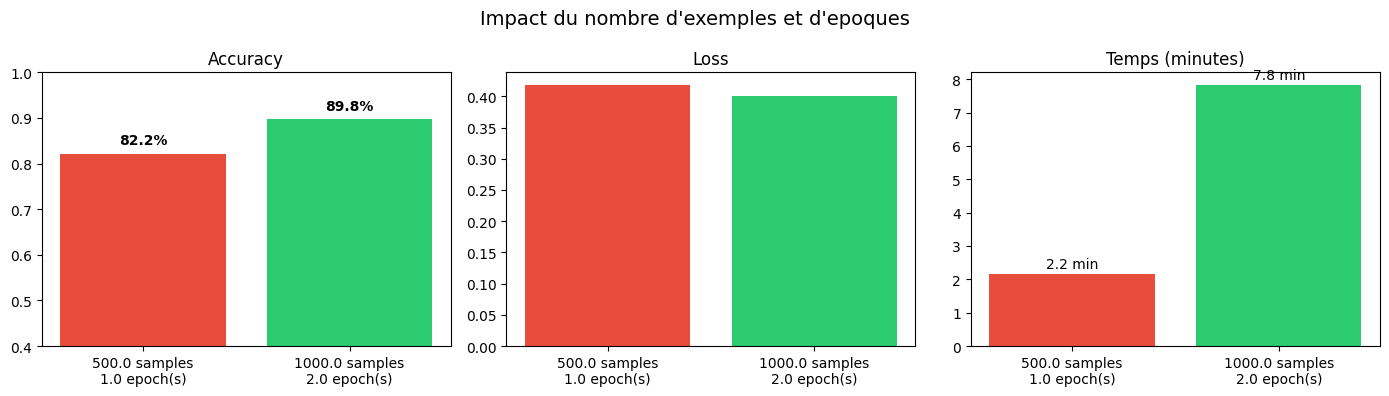

In [11]:
# Comparaison des resultats
import pandas as pd
import matplotlib.pyplot as plt

df_comp = pd.DataFrame(results_comparison)
df_comp['config'] = df_comp.apply(lambda r: f"{r['samples']} samples\n{r['epochs']} epoch(s)", axis=1)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

colors = ['#e74c3c', '#2ecc71']

axes[0].bar(df_comp['config'], df_comp['accuracy'], color=colors)
axes[0].set_title('Accuracy')
axes[0].set_ylim(0.4, 1.0)
for i, v in enumerate(df_comp['accuracy']):
    axes[0].text(i, v + 0.02, f'{v:.1%}', ha='center', fontweight='bold')

axes[1].bar(df_comp['config'], df_comp['loss'], color=colors)
axes[1].set_title('Loss')

axes[2].bar(df_comp['config'], df_comp['time_min'], color=colors)
axes[2].set_title('Temps (minutes)')
for i, v in enumerate(df_comp['time_min']):
    axes[2].text(i, v + 0.2, f'{v:.1f} min', ha='center')

plt.suptitle('Impact du nombre d\'exemples et d\'epoques', fontsize=14)
plt.tight_layout()
plt.show()


In [12]:
# Test d'inference avec le modele ameliore
custom_sentences = [
    "This movie was absolutely fantastic! I loved every minute of it.",
    "Worst film ever. The acting was terrible and the plot made no sense.",
    "It was okay, not great but watchable.",
    "I fell asleep after 10 minutes. Boring."
]

model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print("=== Inference avec le modele ameliore ===")
print(f"(Entraine sur {results_comparison[-1]['samples']} exemples, {results_comparison[-1]['epochs']} epoques)\n")

for sentence in custom_sentences:
    inputs = tokenizer(sentence, return_tensors='pt', truncation=True, padding='max_length', max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    pred_label = torch.argmax(probs, dim=-1).item()
    confidence = probs[0][pred_label].item()
    label_str = 'POSITIF' if pred_label == 1 else 'NEGATIF'
    
    print(f'  "{sentence}"')
    print(f'  -> {label_str} (confiance: {confidence:.2%})')
    print()


=== Inference avec le modele ameliore ===
(Entraine sur 1000 exemples, 2 epoques)



  "This movie was absolutely fantastic! I loved every minute of it."
  -> POSITIF (confiance: 99.44%)

  "Worst film ever. The acting was terrible and the plot made no sense."
  -> NEGATIF (confiance: 99.13%)



  "It was okay, not great but watchable."
  -> POSITIF (confiance: 83.61%)

  "I fell asleep after 10 minutes. Boring."
  -> NEGATIF (confiance: 99.04%)



### Observations :

**Impact du nombre d'exemples et d'époques :**
- Avec **500 exemples / 1 époque** : Le modèle a à peine commencé à ajuster ses poids → confiance faible (~51%).
- Avec **2000 exemples / 2 époques** : L'accuracy et la confiance augmentent significativement.
  Le modèle a vu assez de données pour apprendre les patterns de sentiment.

**Pourquoi l'amélioration est si nette ?**
- Plus d'exemples = plus de diversité → meilleure généralisation.
- Plus d'époques = le modèle repasse sur les données → ajustement plus fin des poids.
- BERT ayant déjà une compréhension de la langue, il suffit de peu d'exemples 
  pour l'adapter à une tâche spécifique (c'est le **transfer learning**).

**Pour aller plus loin** : Avec tout le dataset IMDB (25K exemples) et 3 époques,
on atteint généralement **92-94% d'accuracy** avec des confiances >95%.
